# Learning Text Classification
This is a notebook I created to learn how to set up and perform basic text classification using two classifiers: Naive Bayes and Logistic Regression.  Most of my ML-type data analysis work was previously in regression-based problems so this provided good experience in order for me to expand my knowledge. 


This [link from the sckit-learn website](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) is an extremely good resource that provided good guidance for me to conceptualize things.  I mostly just recreated what was done there in that link in this Jupyter Notebook with additional notes for classification/NLP newbies like me.  


Quick Table of Contents:

1. [Loading Dataset](#Loading-the-20-Newsgroups-Dataset)
2. [Feature Extraction](#Feature-Extraction)
3. [Training Naive Bayes](#Training-a-NB-Classifier)
4. [Training via Pipeline](#Training-via-Pipeline)
5. [Assessing the Performance of Classifiers](#Assessing-the-Performance-of-Classifiers)
6. [Training Logistic Regression](#Training-a-Logistic-Regression-Classifier)

## Loading the 20 Newsgroups Dataset

Apparently the 20 News Grops data is the default "data set for experiments in text applications of machine learning techniques, such as text classification and text clustering". It's kind of like the famous iris dataset. It contains approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups  For background information on this dataset, [check out this link](http://qwone.com/~jason/20Newsgroups/). 

Here we download 4 of the 20 categories of this dataset for both training and testing datasets. 

In [9]:
categories = ['alt.atheism', 'soc.religion.christian',
             'comp.graphics', 'sci.med']


from sklearn.datasets import fetch_20newsgroups

mydata_train = fetch_20newsgroups(subset='train', shuffle=True, categories=categories, 
                                  remove = ('headers', 'footers', 'quotes'), random_state=42)

mydata_test = fetch_20newsgroups(subset='test', shuffle=True, categories=categories, 
                                  remove = ('headers', 'footers', 'quotes'), random_state=42)

print('size of training set: %s' % (len(mydata_train ['data'])))
print('size of validation set: %s' % (len(mydata_test['data'])))
print('classes: %s' % (mydata_train.target_names))

size of training set: 2257
size of validation set: 1502
classes: ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']


Printing the first few lines of one of the items in the training data. 

In [23]:
print("\n".join(mydata_train.data[3].split("\n")[:5]))

Hello,

I'm writing a paper on the role of the catholic church in Poland after 1989. 
Can anyone tell me more about this, or fill me in on recent books/articles(
in english, german or french). Most important for me is the role of the 


In [12]:
mydata_train.target[1:5]

array([1, 3, 3, 3])

Checking the number of each group.

In [24]:
import numpy as np
targets, frequency = np.unique(mydata_train.target, return_counts=True)
targets, frequency

(array([0, 1, 2, 3]), array([480, 584, 594, 599]))

Get an idea of how the classes of this data are distributed

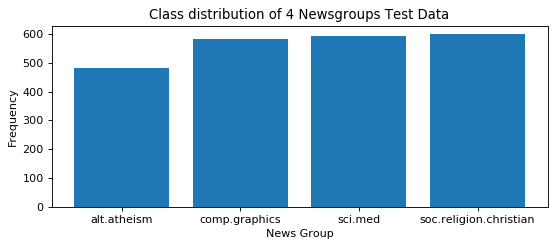

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(mydata_train.target_names, frequency)
plt.title('Class distribution of 4 Newsgroups Test Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

This is a quick DataFrame view of what this dataset looks like

In [48]:
import pandas as pd
mydata_train_df = pd.DataFrame({'data': mydata_train.data, 'target': mydata_train.target})
mydata_train_df.head()

,data,target
0,Does anyone know of a good way (standard PC ap...,1
1,"Hi,\n\n\tI have a problem, I hope some of the ...",1
2,"(Well, I'll email also, but this may apply to ...",3
3,"Hello,\n\nI'm writing a paper on the role of t...",3
4,,3


## Feature Extraction

In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.


### Bags of Words
The most intuitive way to do so is to use a bags of words representation:

Assign a fixed integer id to each word occurring in any document of the training set (for instance by building a dictionary from words to integer indices).  For each document #i, count the number of occurrences of each word w and store it in `X[i, j]` as the value of feature #j where j is the index of word w in the dictionary.

The bags of words representation implies that n_features is the number of distinct words in the corpus: this number is typically larger than 100,000.

Fortunately, most values in `X` will be zeros since for a given document less than a few thousand distinct words will be used. For this reason we say that bags of words are typically high-dimensional sparse datasets. We can save a lot of memory by only storing the non-zero parts of the feature vectors in memory.

`scipy.sparse` matrices are data structures that do exactly this, and `scikit-learn` has built-in support for these structures.

Text preprocessing, tokenizing and filtering of stopwords are all included in [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer), which builds a dictionary of features and transforms documents to feature vectors.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(mydata_train.data)
X_train_counts.shape

(2257, 28865)

CountVectorizer supports counts of N-gram of words or consecutive characters.   
For a quick understanding of what an 'N-grams' means, look at the example under the [Wikipedia page for N-grams of words](https://en.wikipedia.org/wiki/N-gram#:~:text=In%20the%20fields%20of%20computational,a%20text%20or%20speech%20corpus)


Once fitted, the vectorizer has built a dictionary of feature indices. Here we look up the index for the word 'apple'

In [49]:
count_vect.vocabulary_.get(u'apple')

3294

In [54]:
count_vect.vocabulary_.get(u'you')

28767

### Using Frequencies instead of Occurances
Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called `tf` for Term Frequencies.

Another refinement on top of `tf` is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

Words such as `you` or `and` aren't particularly helpeful for understanding what the document is about since 

This downscaling is called `tf–idf` for Term Frequency times Inverse Document Frequency. The first example is for `tf`.  


In [55]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(2257, 28865)

The second example is for TF-IDF.  This is what we'll use to train the classification. 

In [56]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2257, 28865)

## Training a NB Classifier

Now that we have our features, we can train a classifier to try to predict the category of a post. Let’s start with a Naïve Bayes classifier, which provides a nice baseline for this task.

`sckit-learn` has [great documentation](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes) on this classifier.

There are several variants of this classifier; the one most suitable for word counts is the multinomial variant:

In [59]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, mydata_train.target)

Now that we have our model, we'll train it using some sample phrases. 

In [74]:
phrases_new = ['God is love', 'OpenGL on the GPU is fast',  'Dallas County reports record 30 new coronavirus deaths']

X_new_counts = count_vect.transform(phrases_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(phrases_new, predicted):
    print('%r => %s' % (doc, mydata_train.target_names[category]))


'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => comp.graphics
'Dallas County reports record 30 new coronavirus deaths' => sci.med


On these limited new phrases, it does perfectly fine but we need to gauge performance on more data; this is what the test data is for!

## Training via Pipeline 
Note that every step we took before (vectorizer => transformer => classifier) can be abstracted away  by using a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class. 
We demonstrate that here. 

Note that the names vect, tfidf and clf (classifier) are arbitrary. We will use them to perform grid search for suitable hyperparameters below. We can now train the model with a single command:

In [116]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())])

# fittingthe data
text_clf.fit(mydata_train.data, mydata_train.target)
print(text_clf.score(mydata_test.data, mydata_test.target))

0.6691078561917443


So NB has an accuracy rate of 66.9% on the testing data. Let's look at the full metrics

## Assessing the Performance of Classifiers

In [117]:
from sklearn import metrics
predicted = text_clf.predict(mydata_test.data)
print(metrics.classification_report(mydata_test.target, predicted, target_names=mydata_test.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.96      0.08      0.16       319
         comp.graphics       0.94      0.83      0.88       389
               sci.med       0.96      0.67      0.79       396
soc.religion.christian       0.46      0.98      0.63       398

              accuracy                           0.67      1502
             macro avg       0.83      0.64      0.61      1502
          weighted avg       0.82      0.67      0.63      1502



Note that precision is informally defined as the following:
$$precision = \frac{(relevant \hspace{2mm} documents) \cup (classified \hspace{2mm} documents) }{classified \hspace{2mm} documents}$$

We also have the informal definition of recall here: 

$$recall = \frac{(relevant \hspace{2mm} documents) \cup (classified \hspace{2mm} documents) }{relevant \hspace{2mm} documents}$$

So based on what we know about these evaluation metrics, when Multinomial Naive Bayes classifies a document,  it is very likely that it selects the correct one.  

The one category where this does not apply is the `soc.religion.christian` category.    Far too many things in that are incorrect are classified as `soc.religion.christian`, making it have a very low precision.  In fact, based on the recall for the category, many of the things that should be in `alt.atheism` (and to a lesser extent `sci.med`) ends up being categorized as `soc.religion.christian` instead.  Notice that the recall is highest for `soc.religion.christian`, which makes sense. 


The *F measure* is then defined as the harmonic mean of precision and recall.

$$F = 2 \cdot \frac{(precision) \cdot (recall) }{precision + recall}$$

 ## Training a Logistic Regression Classifier

Now we create a pipeline for Logistic Regression.

In [114]:
from sklearn.linear_model import LogisticRegression

text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())])

text_clf.fit(mydata_train.data, mydata_train.target)
print(text_clf.score(mydata_test.data, mydata_test.target))

/Users/shokawano/anaconda3/envs/py_3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shokawano/anaconda3/envs/py_3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7709720372836218


So that's an accuracy of 77% on the testing set.  Not bad!
Here are the full evaluation metrics

In [115]:
predicted = text_clf.predict(mydata_test.data)
print(metrics.classification_report(mydata_test.target, predicted, target_names=mydata_test.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.77      0.50      0.61       319
         comp.graphics       0.74      0.93      0.83       389
               sci.med       0.84      0.80      0.82       396
soc.religion.christian       0.74      0.81      0.77       398

              accuracy                           0.77      1502
             macro avg       0.77      0.76      0.76      1502
          weighted avg       0.77      0.77      0.76      1502



Overall, the logistic regression has a higher recall; this comes at a cost of lower precision. 
The vast improvements are in the recall numbers for `sci.med` and `alt.atheism`, with improvements of 13% and 42% respectively (absolute). 

It is notable that F measure is higher for logistic regression overall. 